In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
import os
import os.path as osp
import sys
import time
from PIL import Image
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torch

In [84]:
%load_ext autoreload
%autoreload 2

os.chdir("/home/kbibas/fbsource/fbcode/fblearner/flow/projects/experimental/cactus")
print(os.getcwd())
print(os.listdir())
sys.path.append(".")

from src.dataset_utils import get_datasets,load_dataset_pkl,load_cf_vectors
from src.download_data import filter_meta_df
from src.manifold_utils import read_data_from_manifold, save_data_to_manifold
from src.lit_utils import LitModel
from src.manifold_utils import read_data_from_manifold
from src.autoencoder_utils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/data/sandcastle/boxes/fbsource/fbcode/fblearner/flow/projects/experimental/cactus
['TARGETS', 'configs', 'src', 'lightning_logs']


In [85]:
# Load pretrained cf vectors
category = 'Electronics'
data_dir = 'product_clustering_fluent2_bucket/tree/cactus/amazon_dataset'
local_dir_path = '/home/kbibas/cactus_outputs/amazon_review_local_dir' # relative to out dir
dataset_pkl_path = osp.join(data_dir, f"{category}.pkl")
cf_vector_base_dir = 'product_clustering_fluent2_bucket/tree/cactus/outputs/train_autoencoder/train_autoencoder_Electronics_20210913_005225'

# Meta data
pkl_dict = load_dataset_pkl(category, dataset_pkl_path, local_dir_path)
meta_df = pkl_dict['meta_df']
meta_df["manifold_img_path"] = meta_df.img_name.apply(
    lambda x: osp.join(data_dir, category, x)
)

# CF vectors
cf_vectors = load_cf_vectors(cf_vector_base_dir, is_use_cf_bias=False)
cf_vector_dim = cf_vectors.size(-1)
cf_vectors = cf_vectors.detach().numpy()

# Pre trained model



print(f'{cf_vectors.shape=}')

cf_vectors.shape=(19565, 32)


In [86]:
# Compute distance matrix: each CF to CF
t0 = time.time()
dist_mat = pairwise_distances(cf_vectors, metric="euclidean")
print(f'{dist_mat.shape=} in {time.time() - t0:.2f} sec')

dist_mat.shape=(19565, 19565) in 6.29 sec


In [87]:
# Visualze most similar vectors
anchor_id = 5

# Sorting the distance for the anchor cf
idx_sorted = np.argsort(dist_mat[anchor_id])
idx_sorted

array([    5,  3943, 10843, ...,   557, 18625, 17872])

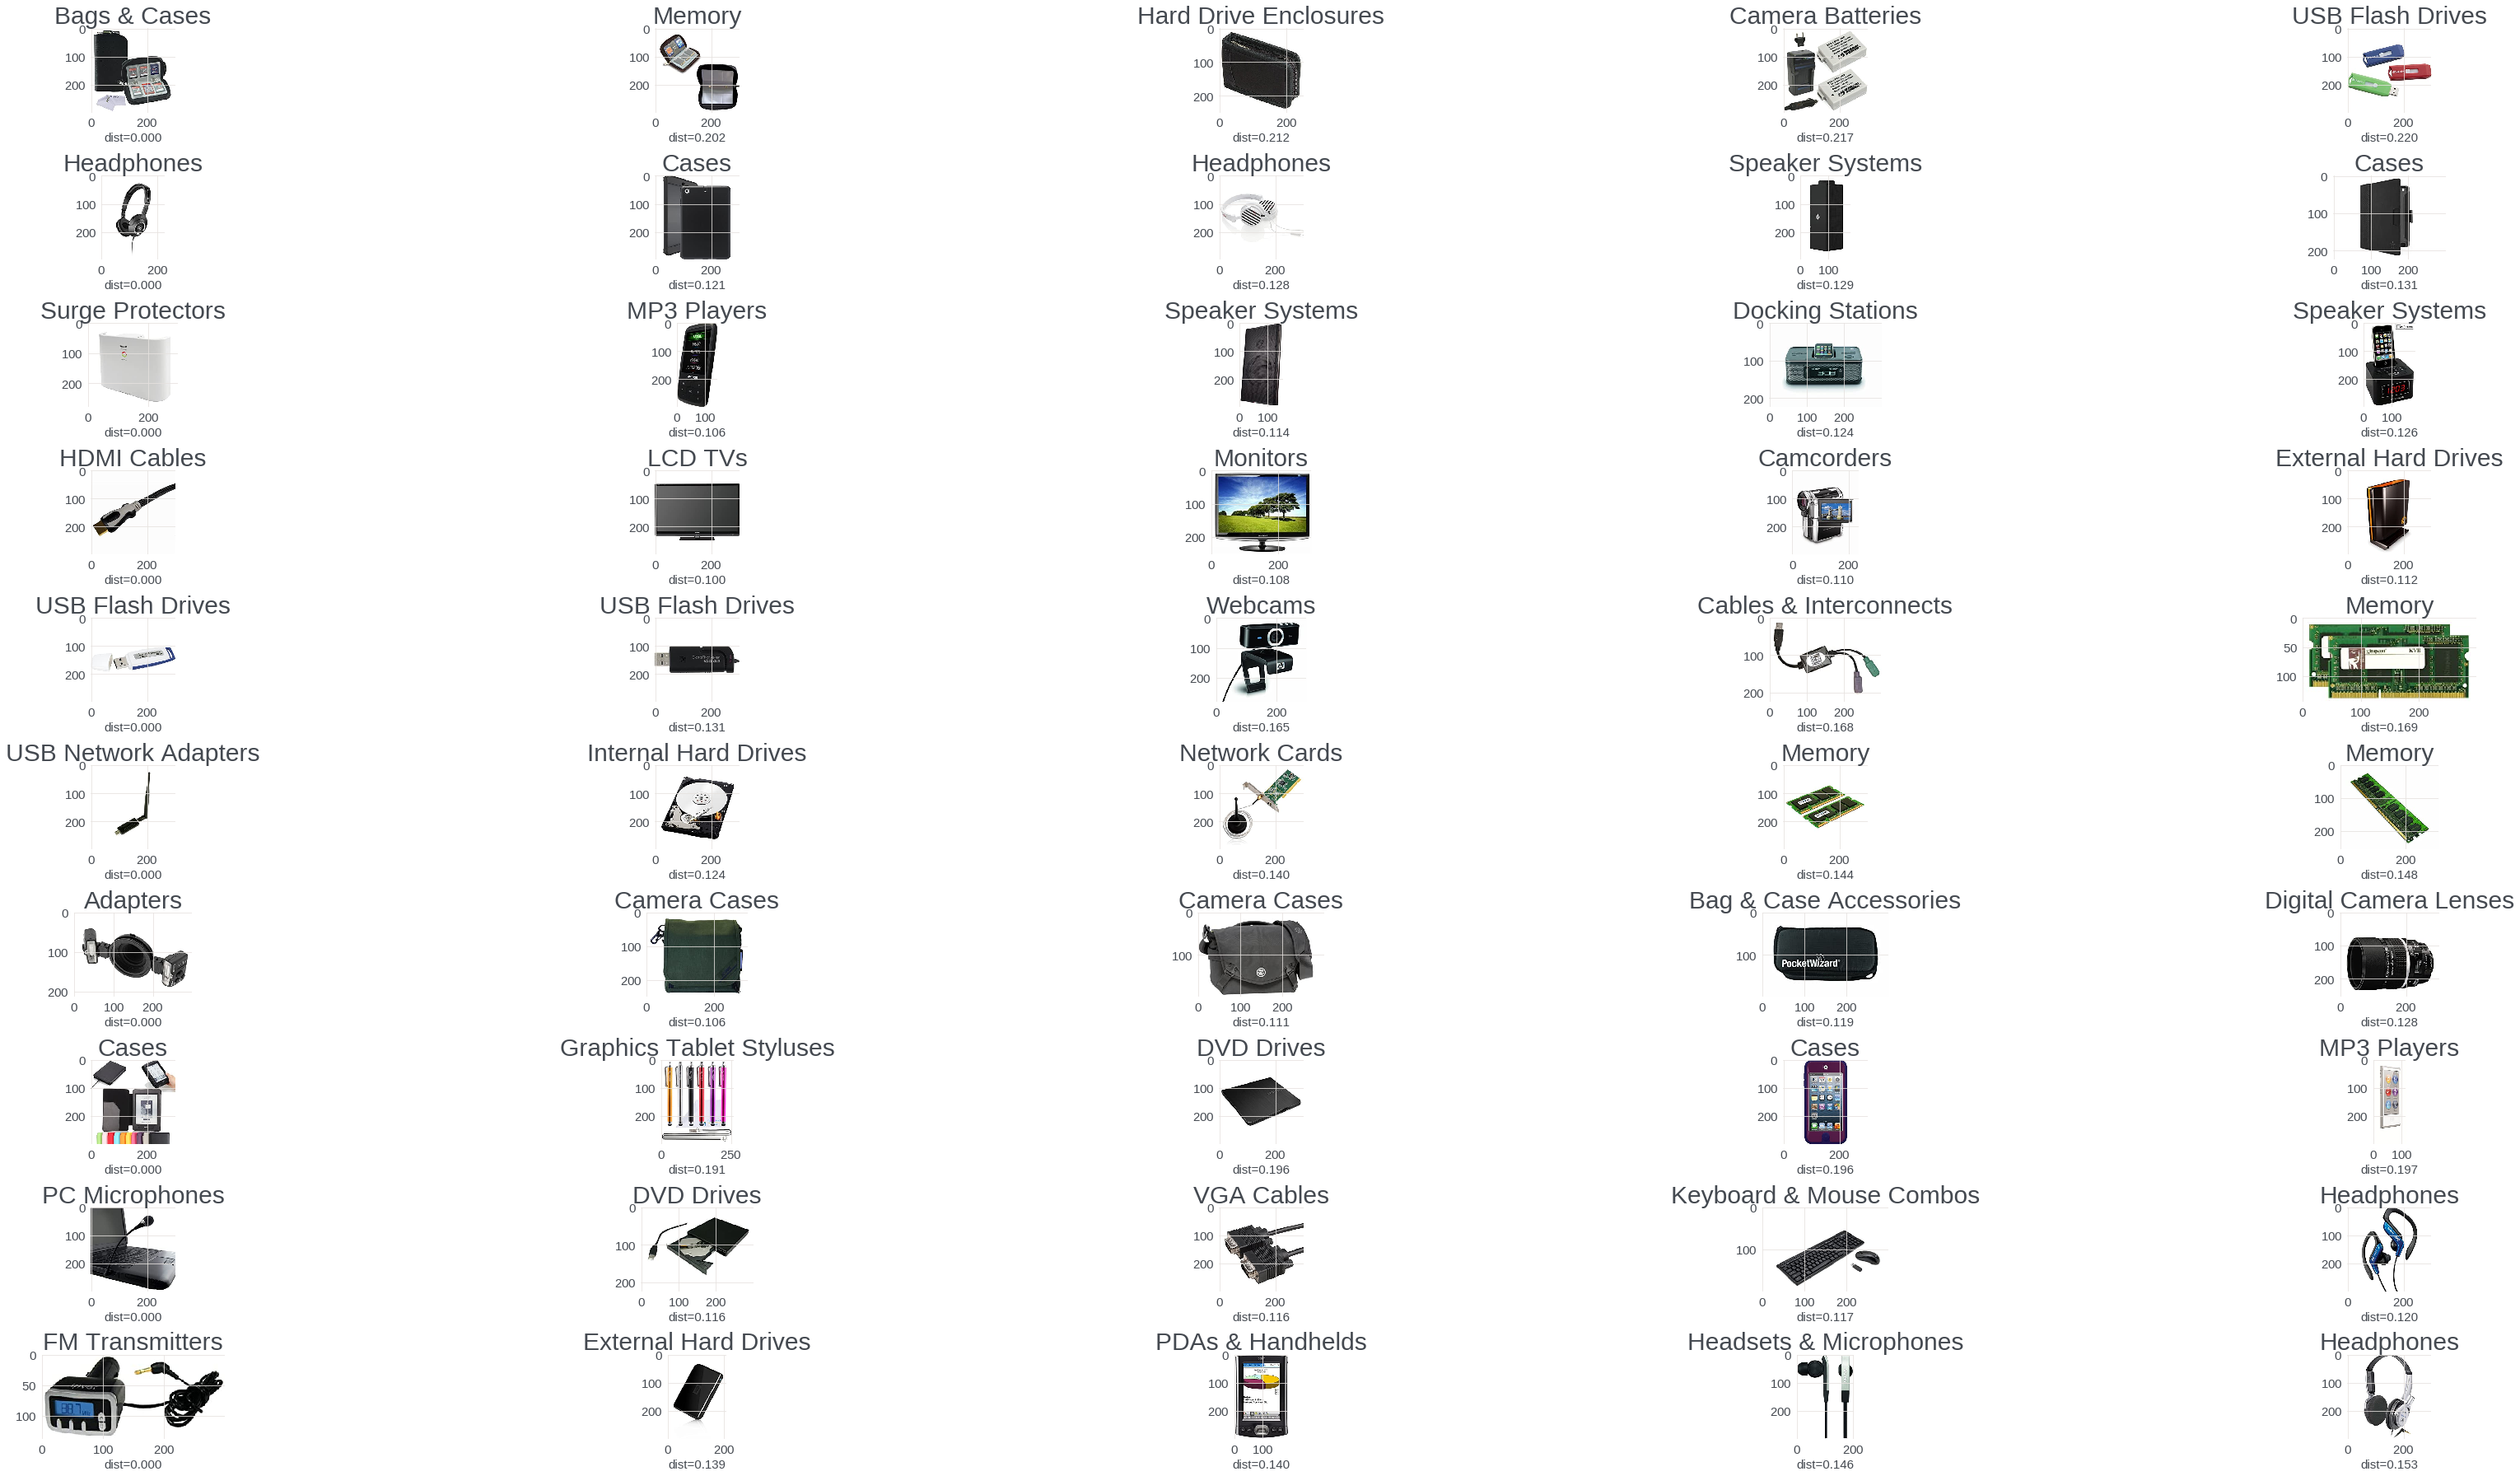

In [88]:
num_anchors = 10
num_imgs = 5

anchor_idxs = np.random.randint(0, high=len(meta_df), size=num_anchors)


fig, axs = plt.subplots(
    num_anchors, num_imgs, facecolor="white", figsize=(num_anchors * 5, num_imgs * 5)
)

for i, anchor_i in enumerate(anchor_idxs):

    # Sorting the distance for the anchor cf
    idx_sorted = np.argsort(dist_mat[anchor_i])[:num_imgs]

    for j, img_j_idx in enumerate(idx_sorted):
        ax = axs[i, j]

        img_byte = read_data_from_manifold(
            meta_df["manifold_img_path"][img_j_idx],
            is_from_pkl=False,
        )
        img = Image.open(img_byte, mode="r").convert("RGB")
        ax.imshow(img)

        dist = dist_mat[anchor_i][img_j_idx]
        ax.set_xlabel(f"{dist=:.3f}")

        ax.set_title(meta_df["categories_org"][img_j_idx])
        # ax.set_axis_off()

plt.tight_layout()
plt.show()


In [89]:
n_clusters = meta_df['categories'].max() 
n_clusters = 100

Clustering

In [90]:
t0 = time.time()
# cf_vectors_norm = cf_vectors/ np.linalg.norm(cf_vectors,axis=-1, keepdims=True)
cf_vectors_norm = cf_vectors
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cf_vectors)
print(f'kmeans in {time.time() -t0 :.2f} sec. {kmeans.cluster_centers_.shape=}')

kmeans in 37.44 sec. kmeans.cluster_centers_.shape=(100, 32)


In [91]:
cluster_dist_mat = pairwise_distances(kmeans.cluster_centers_,cf_vectors_norm, metric="euclidean")
cluster_dist_mat.shape

(100, 19565)

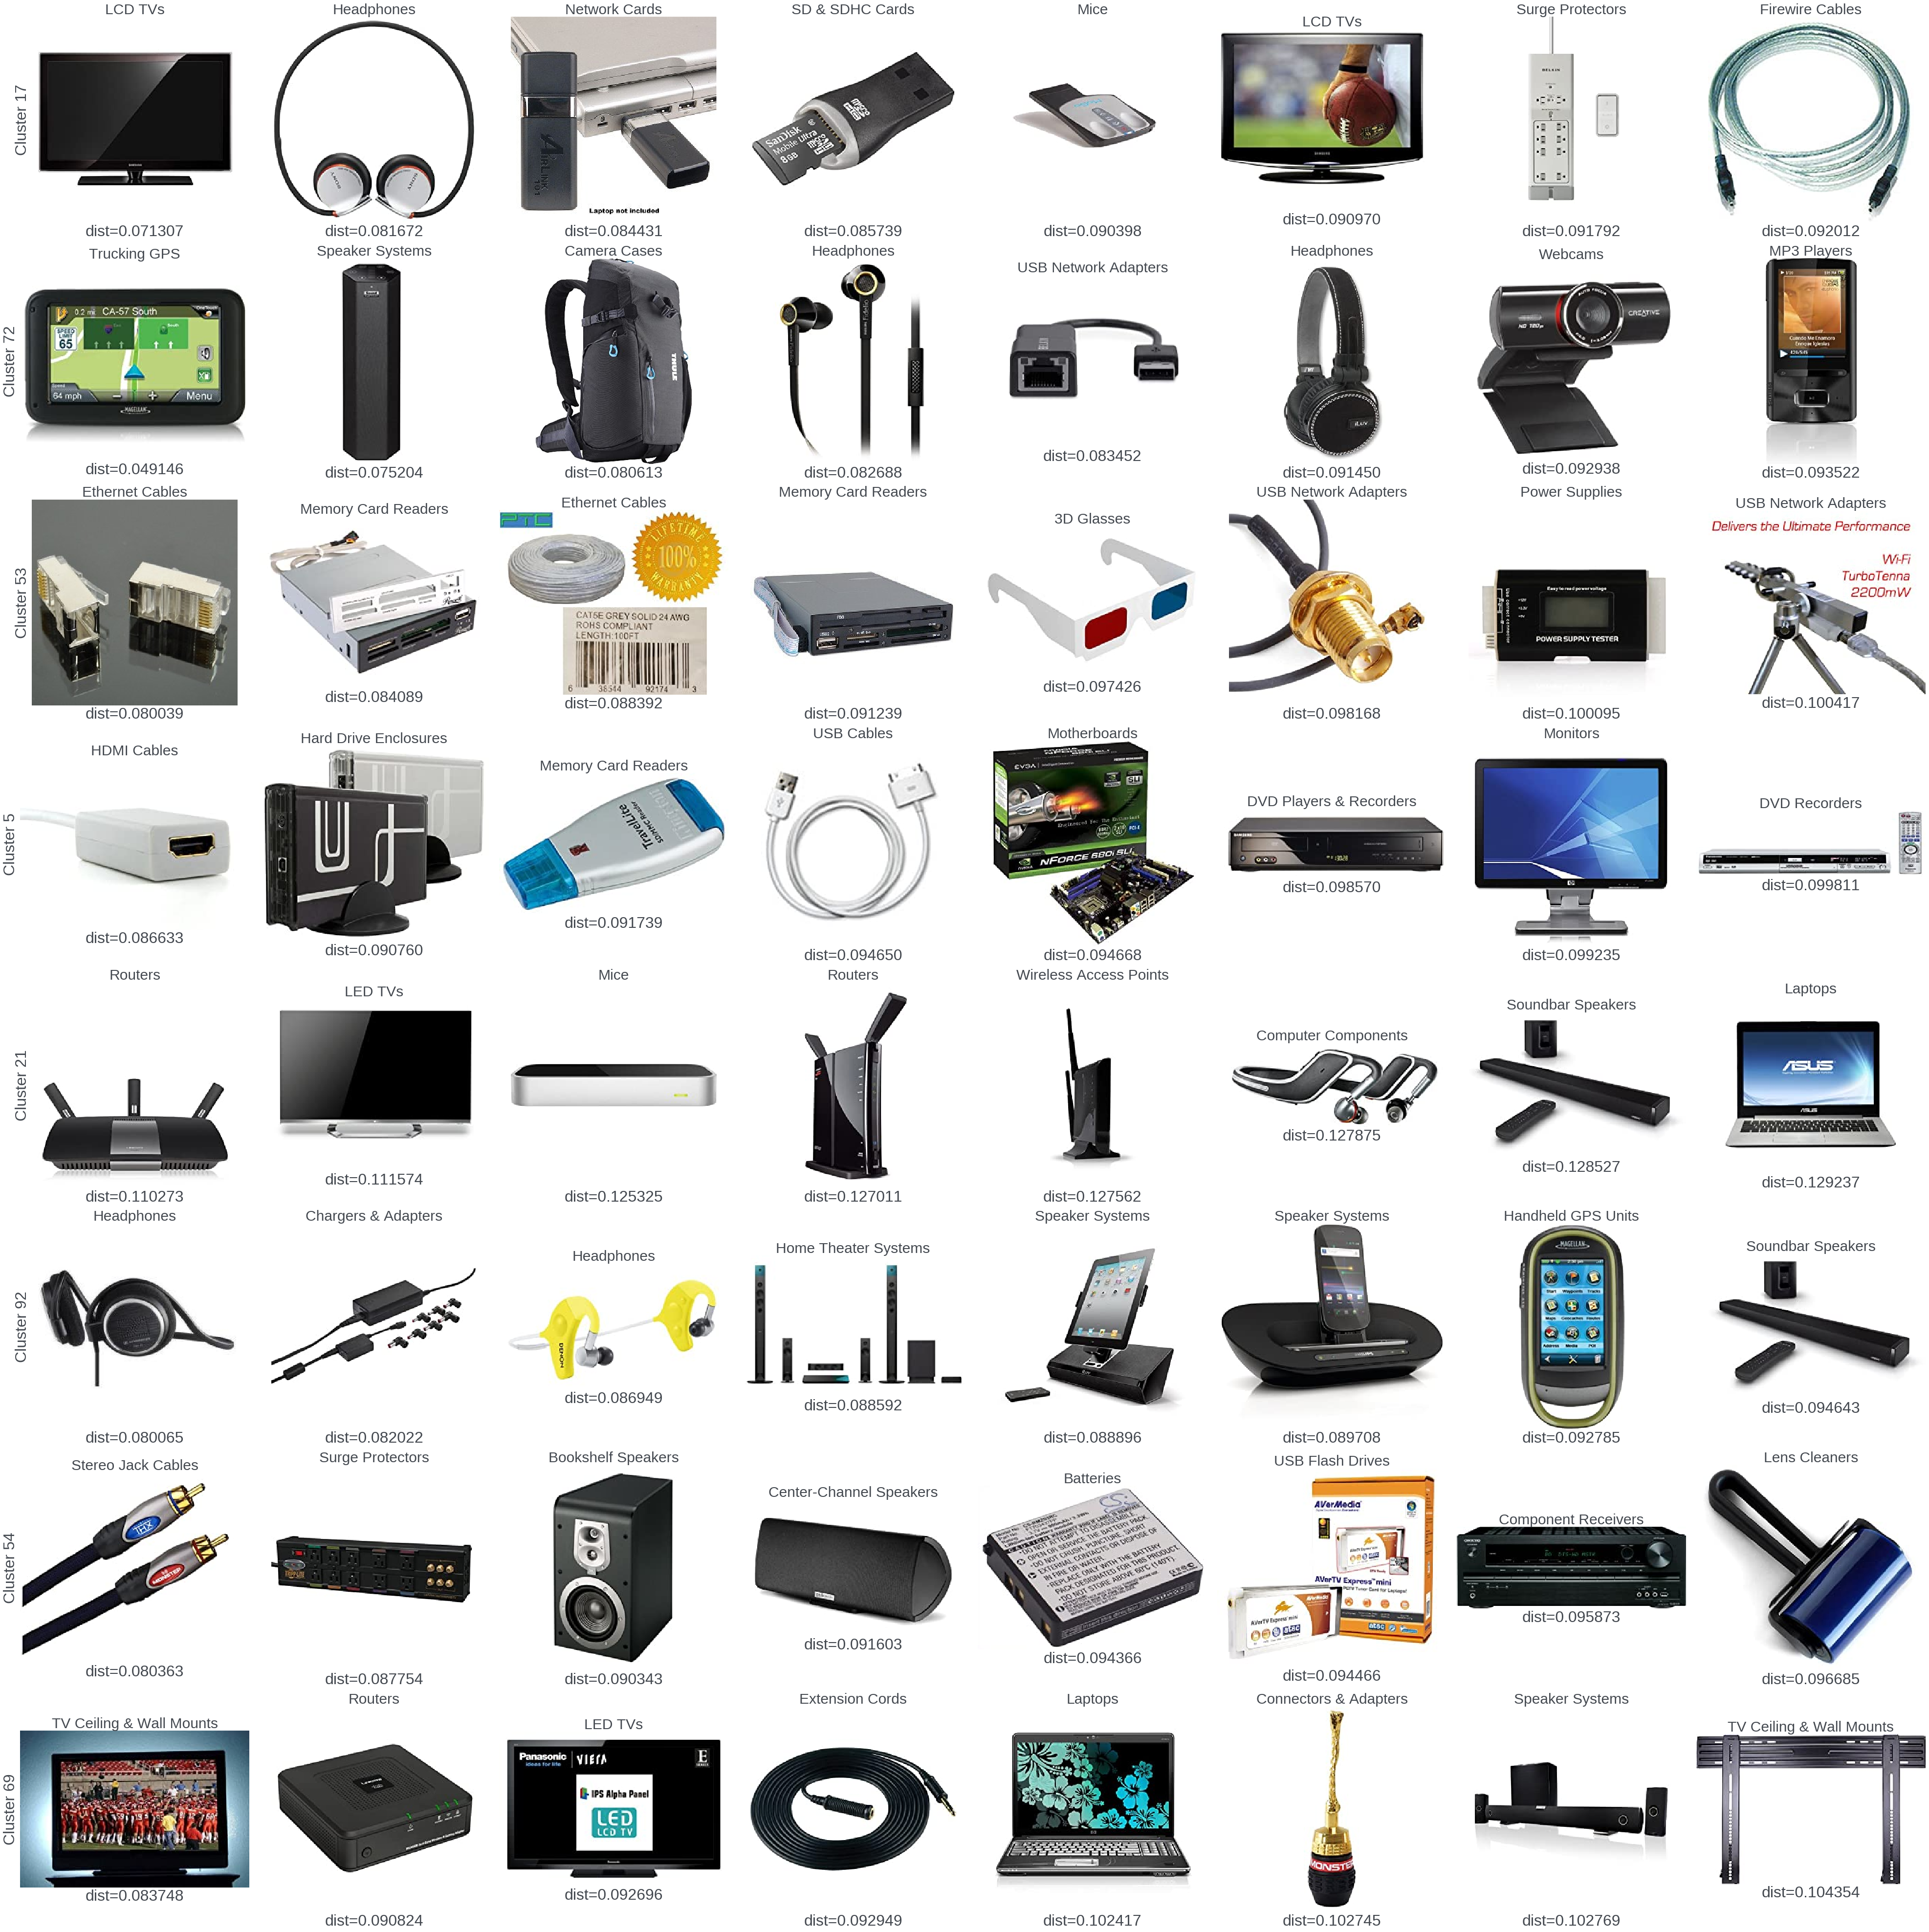

In [92]:
num_clusters = 8
num_imgs = 8

cluster_idxs = np.random.randint(0, high=n_clusters, size=num_clusters)


fig, axs = plt.subplots(num_clusters, num_imgs, facecolor="white", figsize=(55, 55))

for i, cluster_i in enumerate(cluster_idxs):

    # Sorting the distance for the anchor cf
    idx_sorted = np.argsort(cluster_dist_mat[cluster_i])[:num_imgs]

    for j, img_j_idx in enumerate(idx_sorted):
        ax = axs[i, j]

        img_byte = read_data_from_manifold(
            meta_df["manifold_img_path"][img_j_idx],
            is_from_pkl=False,
        )
        img = Image.open(img_byte, mode="r").convert("RGB")
        ax.imshow(img)

        dist = cluster_dist_mat[cluster_i][img_j_idx]
        ax.set_xlabel(f"{dist=:.6f}", fontsize=32)

        ax.set_title(meta_df["categories_org"][img_j_idx])
        ax.set_xticks([])
        ax.set_yticks([])

for row, cluster_idx in enumerate(cluster_idxs):
    axs[row, 0].set_ylabel(f"Cluster {cluster_idx}", fontsize=32)

plt.tight_layout()
plt.show()


# Test performance

In [93]:
cfg = {"gpu": 0, "epochs": 1, "top_k_list": [1, 10, 20, 30, 40, 50], 'emb_size': 32}


In [94]:
ckpt = read_data_from_manifold('product_clustering_fluent2_bucket/tree/cactus/outputs/train_autoencoder/train_autoencoder_Electronics_20210913_005225/epoch=499-step=4999.ckpt',is_from_pkl=False)


In [95]:
lit_h_from_path = AutoEncoderLit.load_from_checkpoint(
    checkpoint_path='/home/kbibas/last.ckpt'
)
lit_h_from_path = AutoEncoderLit.load_from_checkpoint(
    checkpoint_path='/home/kbibas/last.ckpt'
)

In [96]:
# Load data
t0 = time.time()
train_dataset, train_pairs_dataset, test_pairs_dataset = get_autoencoder_datasets(
    data_dir, category, local_dir_path
)

trainloader_pairs = DataLoader(
    train_pairs_dataset,
    num_workers=0,
    batch_size=1024,
    shuffle=False,
)
testloader_pairs = DataLoader(
    test_pairs_dataset,
    num_workers=0,
    batch_size=1024,
    shuffle=False,
)
logger.info(
    f"{len(train_pairs_dataset)=} {len(test_pairs_dataset)=}. In {time.time() -t0 :.2f} sec"
)


I0919 005759.733 autoencoder_utils.py:75] num_users=39990 num_items=19565


I0919 005816.373 <ipython-input-96-a9e6f213376e>:19] len(train_pairs_dataset)=472829 len(test_pairs_dataset)=30478. In 18.61 sec


In [97]:
# Load weights
cf_vectors = load_cf_vectors(cf_vector_base_dir, is_use_cf_bias=True)
item_embs, item_bias = cf_vectors[:, :cfg['emb_size']], cf_vectors[:, cfg['emb_size']:cfg['emb_size']+1]
logger.info(f'{cf_vectors.shape=} {item_embs.shape=}, {item_bias.shape=}')

# Load model
model = AutoEncoderModel(train_dataset.num_items, cfg['emb_size'], 0)

# Initilaize lit
lit_h = AutoEncoderLit.load_from_checkpoint(
    checkpoint_path='/home/kbibas/last.ckpt'
)

lit_h.model.item_embs.weight.data = item_embs.T.detach()
lit_h.model.item_bias.data =  item_bias.detach()

trainer = pl.Trainer(
    progress_bar_refresh_rate=1,
    gpus=[cfg["gpu"]] if torch.cuda.is_available() else None,
)


I0919 005819.711 <ipython-input-97-47125ae6f7c5>:4] cf_vectors.shape=torch.Size([19565, 33]) item_embs.shape=torch.Size([19565, 32]), item_bias.shape=torch.Size([19565, 1])


I0919 005819.755 autoencoder_utils.py:121] AutoEncoderModel __init__: embed_items.shape=torch.Size([19565, 32]) embed_items_bias.shape=torch.Size([19565, 1])


I0919 005819.835 trainer.py:1369] GPU available: True, used: True


I0919 005819.836 trainer.py:1372] TPU available: False, using: 0 TPU cores


I0919 005819.837 trainer.py:1375] IPU available: False, using: 0 IPUs


In [98]:
# Test
trainer.validate(model=lit_h, dataloaders=[trainloader_pairs, testloader_pairs])

W0919 005820.399 trainer.py:910] Local rank 0 started loading cp


W0919 005820.400 trainer.py:926] Local rank 0 finished loading cp


I0919 005820.401 gpu.py:54] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Validating: |          | 0/? [00:00<?, ?it/s]

I0919 010011.346 autoencoder_utils.py:234] [0/499] [0] Val epoch end. loss=0.0000 acc=0.8931


I0919 010011.347 autoencoder_utils.py:234] [0/499] [1] Val epoch end. loss=0.0000 acc=0.7748


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'acc/val_0/dataloader_idx_0': 0.8930712938308716,
 'loss/val_0/dataloader_idx_0': 0.0}
--------------------------------------------------------------------------------
DATALOADER:1 VALIDATE RESULTS
{'acc/val_1/dataloader_idx_1': 0.7746899127960205,
 'loss/val_1/dataloader_idx_1': 0.0}
--------------------------------------------------------------------------------


[{'loss/val_0/dataloader_idx_0': 0.0,
  'acc/val_0/dataloader_idx_0': 0.8930712938308716},
 {'loss/val_1/dataloader_idx_1': 0.0,
  'acc/val_1/dataloader_idx_1': 0.7746899127960205}]

In [99]:
lit_h.calc_topk(
    dataset=test_pairs_dataset, top_k_list=cfg['top_k_list'],tb_logger=None
)

  0%|          | 0/30478 [00:00<?, ?it/s]


  0%|          | 31/30478 [00:00<01:39, 306.77it/s]


  0%|          | 92/30478 [00:00<01:02, 482.54it/s]


  0%|          | 152/30478 [00:00<00:56, 535.19it/s]


  1%|          | 211/30478 [00:00<00:54, 552.78it/s]


  1%|          | 269/30478 [00:00<00:53, 559.65it/s]


  1%|          | 327/30478 [00:00<00:53, 565.19it/s]


  1%|▏         | 385/30478 [00:00<00:53, 567.78it/s]


  1%|▏         | 444/30478 [00:00<00:52, 571.83it/s]


  2%|▏         | 503/30478 [00:00<00:52, 575.15it/s]


  2%|▏         | 561/30478 [00:01<00:52, 573.21it/s]


  2%|▏         | 621/30478 [00:01<00:51, 578.59it/s]


  2%|▏         | 680/30478 [00:01<00:51, 580.08it/s]


  2%|▏         | 739/30478 [00:01<00:51, 579.73it/s]


  3%|▎         | 798/30478 [00:01<00:50, 582.40it/s]


  3%|▎         | 857/30478 [00:01<00:51, 580.44it/s]


  3%|▎         | 916/30478 [00:01<00:51, 577.42it/s]


  3%|▎         | 974/30478 [00:01<00:51, 575.54it/s]


  3%|▎         | 1032/30478 [00:01<00:51, 576.09it/s]


  4%|▎         | 1090/30478 [00:01<00:50, 577.24it/s]


  4%|▍         | 1148/30478 [00:02<00:56, 523.61it/s]


  4%|▍         | 1202/30478 [00:02<00:59, 490.61it/s]


  4%|▍         | 1283/30478 [00:02<00:50, 576.70it/s]


  4%|▍         | 1360/30478 [00:02<00:46, 628.13it/s]


  5%|▍         | 1440/30478 [00:02<00:42, 675.73it/s]


  5%|▍         | 1516/30478 [00:02<00:41, 697.70it/s]


  5%|▌         | 1601/30478 [00:02<00:39, 739.81it/s]


  6%|▌         | 1684/30478 [00:02<00:37, 763.98it/s]


  6%|▌         | 1762/30478 [00:02<00:37, 764.36it/s]


  6%|▌         | 1839/30478 [00:03<00:41, 685.67it/s]


  6%|▋         | 1910/30478 [00:03<00:44, 642.53it/s]


  6%|▋         | 1980/30478 [00:03<00:43, 657.70it/s]


  7%|▋         | 2063/30478 [00:03<00:40, 701.46it/s]


  7%|▋         | 2135/30478 [00:03<00:42, 662.86it/s]


  7%|▋         | 2203/30478 [00:03<00:44, 638.52it/s]


  7%|▋         | 2268/30478 [00:03<00:45, 621.87it/s]


  8%|▊         | 2352/30478 [00:03<00:41, 681.30it/s]


  8%|▊         | 2436/30478 [00:03<00:38, 724.70it/s]


  8%|▊         | 2521/30478 [00:04<00:36, 759.35it/s]


  9%|▊         | 2598/30478 [00:04<00:36, 761.74it/s]


  9%|▉         | 2678/30478 [00:04<00:36, 771.57it/s]


  9%|▉         | 2756/30478 [00:04<00:36, 757.66it/s]


  9%|▉         | 2841/30478 [00:04<00:35, 782.33it/s]


 10%|▉         | 2921/30478 [00:04<00:35, 787.18it/s]


 10%|▉         | 3000/30478 [00:04<00:34, 785.47it/s]


 10%|█         | 3081/30478 [00:04<00:34, 790.11it/s]


 10%|█         | 3165/30478 [00:04<00:34, 803.22it/s]


 11%|█         | 3250/30478 [00:04<00:33, 815.33it/s]


 11%|█         | 3335/30478 [00:05<00:32, 823.62it/s]


 11%|█         | 3418/30478 [00:05<00:33, 814.21it/s]


 11%|█▏        | 3500/30478 [00:05<00:33, 813.95it/s]


 12%|█▏        | 3582/30478 [00:05<00:33, 806.19it/s]


 12%|█▏        | 3663/30478 [00:05<00:36, 731.50it/s]


 12%|█▏        | 3747/30478 [00:05<00:35, 760.22it/s]


 13%|█▎        | 3830/30478 [00:05<00:34, 777.36it/s]


 13%|█▎        | 3917/30478 [00:05<00:33, 803.05it/s]


 13%|█▎        | 3999/30478 [00:05<00:33, 796.70it/s]


 13%|█▎        | 4087/30478 [00:05<00:32, 818.92it/s]


 14%|█▎        | 4172/30478 [00:06<00:31, 827.64it/s]


 14%|█▍        | 4256/30478 [00:06<00:31, 823.59it/s]


 14%|█▍        | 4339/30478 [00:06<00:31, 820.32it/s]


 15%|█▍        | 4422/30478 [00:06<00:32, 794.81it/s]


 15%|█▍        | 4502/30478 [00:06<00:36, 721.43it/s]


 15%|█▌        | 4576/30478 [00:06<00:38, 678.97it/s]


 15%|█▌        | 4646/30478 [00:06<00:39, 650.68it/s]


 15%|█▌        | 4712/30478 [00:06<00:40, 630.82it/s]


 16%|█▌        | 4776/30478 [00:07<00:46, 547.84it/s]


 16%|█▌        | 4833/30478 [00:07<00:51, 500.19it/s]


 16%|█▌        | 4885/30478 [00:07<00:51, 499.79it/s]


 16%|█▋        | 4969/30478 [00:07<00:43, 585.78it/s]


 17%|█▋        | 5046/30478 [00:07<00:40, 634.29it/s]


 17%|█▋        | 5112/30478 [00:07<00:40, 622.51it/s]


 17%|█▋        | 5177/30478 [00:07<00:40, 629.03it/s]


 17%|█▋        | 5261/30478 [00:07<00:36, 687.03it/s]


 18%|█▊        | 5345/30478 [00:07<00:34, 728.90it/s]


 18%|█▊        | 5427/30478 [00:08<00:33, 755.13it/s]


 18%|█▊        | 5510/30478 [00:08<00:32, 776.83it/s]


 18%|█▊        | 5589/30478 [00:08<00:34, 715.76it/s]


 19%|█▊        | 5673/30478 [00:08<00:33, 748.48it/s]


 19%|█▉        | 5749/30478 [00:08<00:34, 706.94it/s]


 19%|█▉        | 5827/30478 [00:08<00:33, 725.36it/s]


 19%|█▉        | 5909/30478 [00:08<00:32, 749.83it/s]


 20%|█▉        | 5988/30478 [00:08<00:32, 759.97it/s]


 20%|█▉        | 6065/30478 [00:08<00:34, 717.44it/s]


 20%|██        | 6145/30478 [00:08<00:32, 739.29it/s]


 20%|██        | 6230/30478 [00:09<00:31, 770.09it/s]


 21%|██        | 6310/30478 [00:09<00:31, 776.57it/s]


 21%|██        | 6389/30478 [00:09<00:33, 727.02it/s]


 21%|██        | 6471/30478 [00:09<00:31, 752.14it/s]


 21%|██▏       | 6550/30478 [00:09<00:31, 760.72it/s]


 22%|██▏       | 6631/30478 [00:09<00:30, 774.89it/s]


 22%|██▏       | 6717/30478 [00:09<00:29, 796.94it/s]


 22%|██▏       | 6798/30478 [00:09<00:29, 798.11it/s]


 23%|██▎       | 6881/30478 [00:09<00:29, 804.51it/s]


 23%|██▎       | 6962/30478 [00:10<00:32, 721.72it/s]


 23%|██▎       | 7036/30478 [00:10<00:34, 675.21it/s]


 23%|██▎       | 7106/30478 [00:10<00:36, 647.75it/s]


 24%|██▎       | 7172/30478 [00:10<00:36, 641.84it/s]


 24%|██▎       | 7237/30478 [00:10<00:37, 626.17it/s]


 24%|██▍       | 7301/30478 [00:10<00:37, 620.24it/s]


 24%|██▍       | 7364/30478 [00:10<00:37, 615.08it/s]


 24%|██▍       | 7451/30478 [00:10<00:33, 685.27it/s]


 25%|██▍       | 7538/30478 [00:10<00:31, 735.61it/s]


 25%|██▍       | 7613/30478 [00:11<00:32, 712.43it/s]


 25%|██▌       | 7696/30478 [00:11<00:30, 745.46it/s]


 26%|██▌       | 7779/30478 [00:11<00:29, 767.41it/s]


 26%|██▌       | 7861/30478 [00:11<00:28, 782.39it/s]


 26%|██▌       | 7947/30478 [00:11<00:28, 802.88it/s]


 26%|██▋       | 8031/30478 [00:11<00:27, 812.17it/s]


 27%|██▋       | 8113/30478 [00:11<00:27, 805.40it/s]


 27%|██▋       | 8194/30478 [00:11<00:27, 805.18it/s]


 27%|██▋       | 8275/30478 [00:11<00:30, 720.06it/s]


 27%|██▋       | 8349/30478 [00:12<00:30, 725.35it/s]


 28%|██▊       | 8432/30478 [00:12<00:29, 753.88it/s]


 28%|██▊       | 8516/30478 [00:12<00:28, 777.50it/s]


 28%|██▊       | 8604/30478 [00:12<00:27, 805.45it/s]


 29%|██▊       | 8689/30478 [00:12<00:26, 817.50it/s]


 29%|██▉       | 8774/30478 [00:12<00:26, 824.96it/s]


 29%|██▉       | 8859/30478 [00:12<00:26, 828.12it/s]


 29%|██▉       | 8944/30478 [00:12<00:25, 832.09it/s]


 30%|██▉       | 9028/30478 [00:12<00:28, 740.61it/s]


 30%|██▉       | 9105/30478 [00:12<00:31, 688.59it/s]


 30%|███       | 9176/30478 [00:13<00:31, 666.14it/s]


 30%|███       | 9260/30478 [00:13<00:29, 712.12it/s]


 31%|███       | 9333/30478 [00:13<00:31, 670.56it/s]


 31%|███       | 9402/30478 [00:13<00:32, 645.01it/s]


 31%|███       | 9468/30478 [00:13<00:33, 626.45it/s]


 31%|███▏      | 9532/30478 [00:13<00:34, 612.75it/s]


 31%|███▏      | 9594/30478 [00:13<00:34, 604.43it/s]


 32%|███▏      | 9655/30478 [00:13<00:34, 596.93it/s]


 32%|███▏      | 9715/30478 [00:13<00:34, 595.17it/s]


 32%|███▏      | 9775/30478 [00:14<00:35, 589.99it/s]


 32%|███▏      | 9835/30478 [00:14<00:35, 587.64it/s]


 32%|███▏      | 9894/30478 [00:14<00:35, 586.27it/s]


 33%|███▎      | 9953/30478 [00:14<00:34, 587.23it/s]


 33%|███▎      | 10012/30478 [00:14<00:34, 587.02it/s]


 33%|███▎      | 10071/30478 [00:14<00:34, 585.41it/s]


 33%|███▎      | 10130/30478 [00:14<00:34, 583.62it/s]


 33%|███▎      | 10189/30478 [00:14<00:34, 584.04it/s]


 34%|███▎      | 10249/30478 [00:14<00:34, 586.55it/s]


 34%|███▍      | 10308/30478 [00:14<00:34, 586.61it/s]


 34%|███▍      | 10367/30478 [00:15<00:34, 584.30it/s]


 34%|███▍      | 10426/30478 [00:15<00:34, 581.89it/s]


 34%|███▍      | 10485/30478 [00:15<00:34, 578.98it/s]


 35%|███▍      | 10544/30478 [00:15<00:34, 581.89it/s]


 35%|███▍      | 10603/30478 [00:15<00:34, 579.76it/s]


 35%|███▍      | 10662/30478 [00:15<00:34, 581.23it/s]


 35%|███▌      | 10721/30478 [00:15<00:33, 581.27it/s]


 35%|███▌      | 10780/30478 [00:15<00:33, 582.62it/s]


 36%|███▌      | 10839/30478 [00:15<00:33, 584.58it/s]


 36%|███▌      | 10898/30478 [00:16<00:33, 584.75it/s]


 36%|███▌      | 10970/30478 [00:16<00:31, 624.35it/s]


 36%|███▋      | 11057/30478 [00:16<00:27, 694.83it/s]


 37%|███▋      | 11144/30478 [00:16<00:25, 746.21it/s]


 37%|███▋      | 11231/30478 [00:16<00:24, 781.28it/s]


 37%|███▋      | 11319/30478 [00:16<00:23, 808.28it/s]


 37%|███▋      | 11400/30478 [00:16<00:26, 727.00it/s]


 38%|███▊      | 11475/30478 [00:16<00:27, 680.47it/s]


 38%|███▊      | 11545/30478 [00:16<00:28, 654.10it/s]


 38%|███▊      | 11612/30478 [00:17<00:29, 634.66it/s]


 38%|███▊      | 11677/30478 [00:17<00:30, 613.88it/s]


 39%|███▊      | 11739/30478 [00:17<00:31, 603.44it/s]


 39%|███▊      | 11800/30478 [00:17<01:07, 278.58it/s]


 39%|███▉      | 11871/30478 [00:17<00:54, 344.13it/s]


 39%|███▉      | 11956/30478 [00:17<00:42, 434.17it/s]


 40%|███▉      | 12040/30478 [00:18<00:35, 516.03it/s]


 40%|███▉      | 12125/30478 [00:18<00:31, 591.08it/s]


 40%|████      | 12210/30478 [00:18<00:27, 652.69it/s]


 40%|████      | 12294/30478 [00:18<00:25, 700.09it/s]


 41%|████      | 12378/30478 [00:18<00:24, 737.46it/s]


 41%|████      | 12463/30478 [00:18<00:23, 766.03it/s]


 41%|████      | 12545/30478 [00:18<00:25, 707.35it/s]


 41%|████▏     | 12620/30478 [00:18<00:26, 668.09it/s]


 42%|████▏     | 12691/30478 [00:18<00:27, 643.29it/s]


 42%|████▏     | 12758/30478 [00:19<00:28, 628.00it/s]


 42%|████▏     | 12838/30478 [00:19<00:26, 673.34it/s]


 42%|████▏     | 12907/30478 [00:19<00:27, 643.95it/s]


 43%|████▎     | 12991/30478 [00:19<00:25, 696.05it/s]


 43%|████▎     | 13075/30478 [00:19<00:23, 735.61it/s]


 43%|████▎     | 13150/30478 [00:19<00:25, 678.97it/s]


 43%|████▎     | 13226/30478 [00:19<00:24, 699.57it/s]


 44%|████▎     | 13312/30478 [00:19<00:23, 743.02it/s]


 44%|████▍     | 13399/30478 [00:19<00:21, 777.18it/s]


 44%|████▍     | 13486/30478 [00:20<00:21, 802.60it/s]


 45%|████▍     | 13573/30478 [00:20<00:20, 821.90it/s]


 45%|████▍     | 13659/30478 [00:20<00:20, 831.60it/s]


 45%|████▌     | 13745/30478 [00:20<00:19, 839.04it/s]


 45%|████▌     | 13832/30478 [00:20<00:19, 847.90it/s]


 46%|████▌     | 13920/30478 [00:20<00:19, 856.13it/s]


 46%|████▌     | 14006/30478 [00:20<00:21, 751.43it/s]


 46%|████▌     | 14084/30478 [00:20<00:23, 699.52it/s]


 46%|████▋     | 14157/30478 [00:20<00:24, 663.95it/s]


 47%|████▋     | 14226/30478 [00:21<00:25, 640.07it/s]


 47%|████▋     | 14292/30478 [00:21<00:25, 623.50it/s]


 47%|████▋     | 14356/30478 [00:21<00:26, 612.33it/s]


 47%|████▋     | 14418/30478 [00:21<00:26, 605.98it/s]


 48%|████▊     | 14479/30478 [00:21<00:26, 603.91it/s]


 48%|████▊     | 14540/30478 [00:21<00:26, 598.72it/s]


 48%|████▊     | 14600/30478 [00:21<00:26, 594.81it/s]


 48%|████▊     | 14660/30478 [00:21<00:26, 593.77it/s]


 48%|████▊     | 14720/30478 [00:21<00:26, 594.20it/s]


 48%|████▊     | 14780/30478 [00:21<00:26, 595.17it/s]


 49%|████▊     | 14840/30478 [00:22<00:26, 592.28it/s]


 49%|████▉     | 14900/30478 [00:22<00:26, 585.80it/s]


 49%|████▉     | 14959/30478 [00:22<00:26, 583.62it/s]


 49%|████▉     | 15026/30478 [00:22<00:25, 608.71it/s]


 50%|████▉     | 15112/30478 [00:22<00:22, 682.81it/s]


 50%|████▉     | 15183/30478 [00:22<00:22, 688.72it/s]


 50%|█████     | 15252/30478 [00:22<00:24, 624.32it/s]


 50%|█████     | 15316/30478 [00:22<00:25, 593.78it/s]


 51%|█████     | 15393/30478 [00:22<00:23, 641.39it/s]


 51%|█████     | 15479/30478 [00:23<00:21, 701.03it/s]


 51%|█████     | 15564/30478 [00:23<00:20, 742.22it/s]


 51%|█████▏    | 15640/30478 [00:23<00:21, 683.62it/s]


 52%|█████▏    | 15710/30478 [00:23<00:22, 650.70it/s]


 52%|█████▏    | 15777/30478 [00:23<00:23, 629.89it/s]


 52%|█████▏    | 15841/30478 [00:23<00:23, 613.01it/s]


 52%|█████▏    | 15903/30478 [00:23<00:24, 599.72it/s]


 52%|█████▏    | 15964/30478 [00:23<00:24, 591.50it/s]


 53%|█████▎    | 16024/30478 [00:23<00:24, 587.74it/s]


 53%|█████▎    | 16083/30478 [00:24<00:24, 586.94it/s]


 53%|█████▎    | 16142/30478 [00:24<00:24, 585.62it/s]


 53%|█████▎    | 16201/30478 [00:24<00:24, 586.02it/s]


 53%|█████▎    | 16260/30478 [00:24<00:24, 584.25it/s]


 54%|█████▎    | 16319/30478 [00:24<00:24, 583.69it/s]


 54%|█████▎    | 16378/30478 [00:24<00:24, 580.90it/s]


 54%|█████▍    | 16437/30478 [00:24<00:24, 581.97it/s]


 54%|█████▍    | 16496/30478 [00:24<00:24, 581.01it/s]


 54%|█████▍    | 16555/30478 [00:24<00:23, 583.56it/s]


 55%|█████▍    | 16636/30478 [00:24<00:21, 649.24it/s]


 55%|█████▍    | 16723/30478 [00:25<00:19, 713.23it/s]


 55%|█████▌    | 16795/30478 [00:25<00:23, 576.53it/s]


 55%|█████▌    | 16857/30478 [00:25<00:26, 514.09it/s]


 55%|█████▌    | 16913/30478 [00:25<00:28, 478.98it/s]


 56%|█████▌    | 16964/30478 [00:25<00:29, 452.97it/s]


 56%|█████▌    | 17012/30478 [00:25<00:30, 440.28it/s]


 56%|█████▌    | 17058/30478 [00:25<00:31, 430.70it/s]


 56%|█████▌    | 17102/30478 [00:26<00:31, 429.04it/s]


 56%|█████▋    | 17189/30478 [00:26<00:24, 546.13it/s]


 57%|█████▋    | 17276/30478 [00:26<00:20, 634.38it/s]


 57%|█████▋    | 17342/30478 [00:26<00:21, 617.24it/s]


 57%|█████▋    | 17424/30478 [00:26<00:19, 672.97it/s]


 57%|█████▋    | 17510/30478 [00:26<00:17, 724.02it/s]


 58%|█████▊    | 17584/30478 [00:26<00:19, 668.59it/s]


 58%|█████▊    | 17653/30478 [00:26<00:20, 640.56it/s]


 58%|█████▊    | 17719/30478 [00:26<00:20, 627.54it/s]


 58%|█████▊    | 17788/30478 [00:26<00:19, 643.48it/s]


 59%|█████▊    | 17877/30478 [00:27<00:17, 710.40it/s]


 59%|█████▉    | 17965/30478 [00:27<00:16, 758.21it/s]


 59%|█████▉    | 18055/30478 [00:27<00:15, 796.44it/s]


 60%|█████▉    | 18144/30478 [00:27<00:15, 820.99it/s]


 60%|█████▉    | 18232/30478 [00:27<00:14, 837.64it/s]


 60%|██████    | 18319/30478 [00:27<00:14, 846.05it/s]


 60%|██████    | 18407/30478 [00:27<00:14, 854.36it/s]


 61%|██████    | 18494/30478 [00:27<00:13, 858.47it/s]


 61%|██████    | 18582/30478 [00:27<00:13, 864.76it/s]


 61%|██████▏   | 18669/30478 [00:27<00:13, 866.06it/s]


 62%|██████▏   | 18756/30478 [00:28<00:13, 865.24it/s]


 62%|██████▏   | 18844/30478 [00:28<00:13, 867.23it/s]


 62%|██████▏   | 18931/30478 [00:28<00:13, 862.50it/s]


 62%|██████▏   | 19018/30478 [00:28<00:13, 860.06it/s]


 63%|██████▎   | 19105/30478 [00:28<00:13, 859.75it/s]


 63%|██████▎   | 19192/30478 [00:28<00:13, 860.91it/s]


 63%|██████▎   | 19279/30478 [00:28<00:13, 847.94it/s]


 64%|██████▎   | 19365/30478 [00:28<00:13, 848.77it/s]


 64%|██████▍   | 19452/30478 [00:28<00:12, 853.50it/s]


 64%|██████▍   | 19538/30478 [00:29<00:12, 853.70it/s]


 64%|██████▍   | 19624/30478 [00:29<00:12, 841.85it/s]


 65%|██████▍   | 19711/30478 [00:29<00:12, 848.70it/s]


 65%|██████▍   | 19798/30478 [00:29<00:12, 852.74it/s]


 65%|██████▌   | 19884/30478 [00:29<00:12, 854.88it/s]


 66%|██████▌   | 19972/30478 [00:29<00:12, 860.26it/s]


 66%|██████▌   | 20060/30478 [00:29<00:12, 863.56it/s]


 66%|██████▌   | 20147/30478 [00:29<00:12, 859.52it/s]


 66%|██████▋   | 20233/30478 [00:29<00:13, 753.92it/s]


 67%|██████▋   | 20315/30478 [00:29<00:13, 769.87it/s]


 67%|██████▋   | 20401/30478 [00:30<00:12, 794.90it/s]


 67%|██████▋   | 20486/30478 [00:30<00:12, 808.46it/s]


 67%|██████▋   | 20572/30478 [00:30<00:12, 823.18it/s]


 68%|██████▊   | 20656/30478 [00:30<00:13, 747.58it/s]


 68%|██████▊   | 20742/30478 [00:30<00:12, 776.87it/s]


 68%|██████▊   | 20829/30478 [00:30<00:12, 801.96it/s]


 69%|██████▊   | 20917/30478 [00:30<00:11, 822.69it/s]


 69%|██████▉   | 21005/30478 [00:30<00:11, 837.77it/s]


 69%|██████▉   | 21092/30478 [00:30<00:11, 843.01it/s]


 69%|██████▉   | 21177/30478 [00:31<00:13, 713.36it/s]


 70%|██████▉   | 21262/30478 [00:31<00:12, 747.72it/s]


 70%|███████   | 21349/30478 [00:31<00:11, 779.81it/s]


 70%|███████   | 21435/30478 [00:31<00:11, 801.45it/s]


 71%|███████   | 21523/30478 [00:31<00:10, 822.38it/s]


 71%|███████   | 21607/30478 [00:31<00:10, 821.06it/s]


 71%|███████   | 21692/30478 [00:31<00:10, 828.95it/s]


 71%|███████▏  | 21776/30478 [00:31<00:10, 806.63it/s]


 72%|███████▏  | 21858/30478 [00:31<00:11, 762.67it/s]


 72%|███████▏  | 21936/30478 [00:32<00:11, 725.38it/s]


 72%|███████▏  | 22021/30478 [00:32<00:11, 759.51it/s]


 73%|███████▎  | 22109/30478 [00:32<00:10, 792.67it/s]


 73%|███████▎  | 22195/30478 [00:32<00:10, 811.72it/s]


 73%|███████▎  | 22281/30478 [00:32<00:09, 824.51it/s]


 73%|███████▎  | 22366/30478 [00:32<00:09, 830.61it/s]


 74%|███████▎  | 22454/30478 [00:32<00:09, 842.34it/s]


 74%|███████▍  | 22540/30478 [00:32<00:09, 844.98it/s]


 74%|███████▍  | 22626/30478 [00:32<00:09, 849.37it/s]


 75%|███████▍  | 22712/30478 [00:32<00:09, 851.97it/s]


 75%|███████▍  | 22800/30478 [00:33<00:08, 858.74it/s]


 75%|███████▌  | 22886/30478 [00:33<00:08, 859.09it/s]


 75%|███████▌  | 22973/30478 [00:33<00:08, 858.90it/s]


 76%|███████▌  | 23060/30478 [00:33<00:08, 860.91it/s]


 76%|███████▌  | 23147/30478 [00:33<00:08, 860.44it/s]


 76%|███████▌  | 23234/30478 [00:33<00:08, 862.02it/s]


 77%|███████▋  | 23321/30478 [00:33<00:08, 863.34it/s]


 77%|███████▋  | 23408/30478 [00:33<00:08, 863.28it/s]


 77%|███████▋  | 23495/30478 [00:33<00:08, 861.61it/s]


 77%|███████▋  | 23582/30478 [00:33<00:08, 858.04it/s]


 78%|███████▊  | 23669/30478 [00:34<00:07, 860.47it/s]


 78%|███████▊  | 23757/30478 [00:34<00:07, 864.41it/s]


 78%|███████▊  | 23844/30478 [00:34<00:07, 845.73it/s]


 79%|███████▊  | 23930/30478 [00:34<00:07, 848.68it/s]


 79%|███████▉  | 24016/30478 [00:34<00:07, 850.58it/s]


 79%|███████▉  | 24102/30478 [00:34<00:08, 750.65it/s]


 79%|███████▉  | 24180/30478 [00:34<00:09, 696.56it/s]


 80%|███████▉  | 24252/30478 [00:34<00:09, 662.39it/s]


 80%|███████▉  | 24320/30478 [00:34<00:09, 651.93it/s]


 80%|████████  | 24407/30478 [00:35<00:08, 710.06it/s]


 80%|████████  | 24494/30478 [00:35<00:07, 753.37it/s]


 81%|████████  | 24579/30478 [00:35<00:07, 779.31it/s]


 81%|████████  | 24664/30478 [00:35<00:07, 798.75it/s]


 81%|████████  | 24750/30478 [00:35<00:07, 814.72it/s]


 81%|████████▏ | 24836/30478 [00:35<00:06, 825.56it/s]


 82%|████████▏ | 24920/30478 [00:35<00:06, 829.56it/s]


 82%|████████▏ | 25004/30478 [00:35<00:06, 828.66it/s]


 82%|████████▏ | 25089/30478 [00:35<00:06, 832.25it/s]


 83%|████████▎ | 25173/30478 [00:35<00:06, 832.73it/s]


 83%|████████▎ | 25257/30478 [00:36<00:06, 829.70it/s]


 83%|████████▎ | 25342/30478 [00:36<00:06, 834.98it/s]


 83%|████████▎ | 25426/30478 [00:36<00:06, 832.55it/s]


 84%|████████▎ | 25511/30478 [00:36<00:05, 835.89it/s]


 84%|████████▍ | 25595/30478 [00:36<00:05, 835.90it/s]


 84%|████████▍ | 25681/30478 [00:36<00:05, 840.16it/s]


 85%|████████▍ | 25766/30478 [00:36<00:05, 838.73it/s]


 85%|████████▍ | 25850/30478 [00:36<00:05, 837.46it/s]


 85%|████████▌ | 25934/30478 [00:36<00:05, 835.04it/s]


 85%|████████▌ | 26018/30478 [00:36<00:05, 830.86it/s]


 86%|████████▌ | 26102/30478 [00:37<00:05, 824.24it/s]


 86%|████████▌ | 26185/30478 [00:37<00:05, 824.90it/s]


 86%|████████▌ | 26268/30478 [00:37<00:05, 824.72it/s]


 86%|████████▋ | 26353/30478 [00:37<00:04, 829.95it/s]


 87%|████████▋ | 26438/30478 [00:37<00:04, 834.46it/s]


 87%|████████▋ | 26522/30478 [00:37<00:04, 825.27it/s]


 87%|████████▋ | 26605/30478 [00:37<00:05, 735.82it/s]


 88%|████████▊ | 26681/30478 [00:37<00:05, 683.75it/s]


 88%|████████▊ | 26752/30478 [00:37<00:05, 672.68it/s]


 88%|████████▊ | 26821/30478 [00:38<00:05, 662.46it/s]


 88%|████████▊ | 26888/30478 [00:38<00:05, 653.24it/s]


 88%|████████▊ | 26954/30478 [00:38<00:05, 651.92it/s]


 89%|████████▊ | 27020/30478 [00:38<00:05, 638.20it/s]


 89%|████████▉ | 27105/30478 [00:38<00:04, 696.55it/s]


 89%|████████▉ | 27176/30478 [00:38<00:05, 659.59it/s]


 89%|████████▉ | 27243/30478 [00:38<00:05, 636.02it/s]


 90%|████████▉ | 27308/30478 [00:38<00:05, 623.18it/s]


 90%|████████▉ | 27371/30478 [00:38<00:05, 583.98it/s]


 90%|█████████ | 27433/30478 [00:39<00:05, 592.32it/s]


 90%|█████████ | 27495/30478 [00:39<00:04, 597.73it/s]


 90%|█████████ | 27557/30478 [00:39<00:04, 601.45it/s]


 91%|█████████ | 27621/30478 [00:39<00:04, 611.27it/s]


 91%|█████████ | 27684/30478 [00:39<00:04, 615.81it/s]


 91%|█████████ | 27746/30478 [00:39<00:04, 591.18it/s]


 91%|█████████ | 27806/30478 [00:39<00:04, 588.31it/s]


 91%|█████████▏| 27866/30478 [00:39<00:04, 583.21it/s]


 92%|█████████▏| 27928/30478 [00:39<00:04, 592.93it/s]


 92%|█████████▏| 27988/30478 [00:40<00:04, 530.89it/s]


 92%|█████████▏| 28043/30478 [00:40<00:04, 492.81it/s]


 92%|█████████▏| 28094/30478 [00:40<00:05, 472.62it/s]


 92%|█████████▏| 28143/30478 [00:40<00:04, 474.79it/s]


 93%|█████████▎| 28207/30478 [00:40<00:04, 517.80it/s]


 93%|█████████▎| 28282/30478 [00:40<00:03, 581.35it/s]


 93%|█████████▎| 28342/30478 [00:40<00:03, 581.89it/s]


 93%|█████████▎| 28401/30478 [00:40<00:03, 579.38it/s]


 93%|█████████▎| 28481/30478 [00:40<00:03, 643.00it/s]


 94%|█████████▎| 28567/30478 [00:41<00:02, 706.32it/s]


 94%|█████████▍| 28651/30478 [00:41<00:02, 744.90it/s]


 94%|█████████▍| 28737/30478 [00:41<00:02, 776.97it/s]


 95%|█████████▍| 28825/30478 [00:41<00:02, 805.98it/s]


 95%|█████████▍| 28912/30478 [00:41<00:01, 824.67it/s]


 95%|█████████▌| 28997/30478 [00:41<00:01, 830.26it/s]


 95%|█████████▌| 29081/30478 [00:41<00:01, 819.02it/s]


 96%|█████████▌| 29168/30478 [00:41<00:01, 832.49it/s]


 96%|█████████▌| 29252/30478 [00:41<00:01, 824.15it/s]


 96%|█████████▋| 29340/30478 [00:41<00:01, 838.06it/s]


 97%|█████████▋| 29429/30478 [00:42<00:01, 849.77it/s]


 97%|█████████▋| 29515/30478 [00:42<00:01, 778.33it/s]


 97%|█████████▋| 29602/30478 [00:42<00:01, 801.74it/s]


 97%|█████████▋| 29689/30478 [00:42<00:00, 820.41it/s]


 98%|█████████▊| 29777/30478 [00:42<00:00, 835.34it/s]


 98%|█████████▊| 29862/30478 [00:42<00:00, 836.91it/s]


 98%|█████████▊| 29948/30478 [00:42<00:00, 843.27it/s]


 99%|█████████▊| 30033/30478 [00:42<00:00, 844.60it/s]


 99%|█████████▉| 30119/30478 [00:42<00:00, 847.51it/s]


 99%|█████████▉| 30204/30478 [00:42<00:00, 817.24it/s]


 99%|█████████▉| 30287/30478 [00:43<00:00, 767.24it/s]


100%|█████████▉| 30365/30478 [00:43<00:00, 719.43it/s]


100%|██████████| 30478/30478 [00:43<00:00, 698.33it/s]
I0919 010055.571 autoencoder_utils.py:286] top_k=1 precision_val=tensor(0.3544)


I0919 010055.573 autoencoder_utils.py:286] top_k=10 precision_val=tensor(1.9457)


I0919 010055.574 autoencoder_utils.py:286] top_k=20 precision_val=tensor(3.2548)


I0919 010055.575 autoencoder_utils.py:286] top_k=30 precision_val=tensor(4.2654)


I0919 010055.576 autoencoder_utils.py:286] top_k=40 precision_val=tensor(5.1906)


I0919 010055.577 autoencoder_utils.py:286] top_k=50 precision_val=tensor(6.0601)


# Plot accuracy

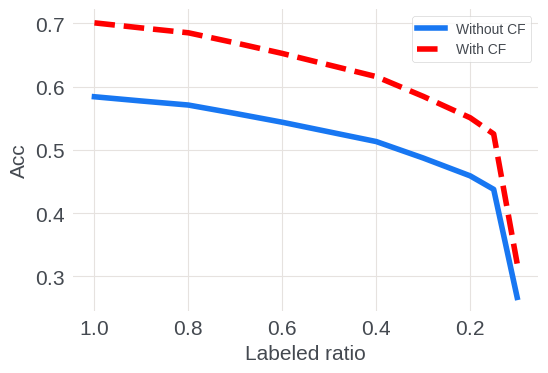

In [100]:
fig ,ax = plt.subplots(1,1,facecolor='white',dpi=100)
label_ratio = [1,	0.9	,0.8,	0.7,	0.6,		0.4,	0.3,	0.2,	0.15,	0.1]
acc = [0.5839,0.5772,	0.5708,	0.5575,	0.5436,		0.5131	,0.4871,	0.4589,	0.4376,	0.2669]
plt.plot(label_ratio, acc,label='Without CF')
plt.plot(label_ratio, np.array(acc)*1.2,'r--', label='With CF')
ax.invert_xaxis()
plt.legend()
plt.xlabel('Labeled ratio')
plt.ylabel('Acc')
plt.show()